In [1]:
import cv2
import numpy as np
from torchvision.transforms import functional as TF

class AddEdgeChannel:
    def __call__(self, img):
        # PIL.Image -> numpy array
        img_np = np.array(img)
        # Convert to grayscale -> edge detection
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        edge = cv2.Canny(gray, 100, 200)
        edge = edge.astype(np.float32) / 255.0 
        edge = np.expand_dims(edge, axis=2)  
        rgba = np.concatenate([img_np, edge * 255], axis=2).astype(np.uint8)
        return Image.fromarray(rgba)

In [5]:
print("GPU is available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))

GPU is available: True
GPU name: Tesla P100-PCIE-16GB


In [2]:
import os, time, cv2, numpy as np
from PIL import Image, ImageDraw
import torch
from ultralytics import YOLO
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# The 4-channel RGBA processing on full dataset

In [7]:
# ----------------------
# 1. Dataset (same as before, only outputs 3-channel full image Tensor)
# ----------------------
class DogVsAiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "Images")
        self.label_dir = os.path.join(root_dir, "Labels")
        self.transform = transform
        self.names = [f.split('.')[0] 
                      for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
    def __len__(self):
        return len(self.names)
    def __getitem__(self, idx):
        name = self.names[idx]
        img = Image.open(os.path.join(self.image_dir, name+".jpg")).convert("RGB")
        if self.transform: img = self.transform(img)
        lbl = int(open(os.path.join(self.label_dir, name+".txt")).read().strip())
        return img, lbl

# ----------------------
# 2. Transforms
# ----------------------
# —— Data augmentation & 4-channel transform —— 
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    AddEdgeChannel(),    # RGBA
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406,0.5],
                         std =[0.229,0.224,0.225,0.5])
])

# ----------------------
# 3. DataLoaders (CUTTED random subset can also directly replace paths)
# ----------------------
train_ds = DogVsAiDataset("/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs/Dogs Vs AiDogs/Train", transform)
val_ds   = DogVsAiDataset("/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs/Dogs Vs AiDogs/Valid", transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)

for i, (img, label) in enumerate(train_loader):
    print(f"Batch {i}, shape: {img.shape}, label: {label}")
    if i == 2:
        break

# ----------------------
# 4. Dual-Branch Model Definition
# ----------------------
class DualBranchNet(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        # —— Global branch backbone —— 
        self.global_backbone = models.resnet50(pretrained=True)
        orig1 = self.global_backbone.conv1
        self.global_backbone.conv1 = nn.Conv2d(
            4, orig1.out_channels,
            kernel_size=orig1.kernel_size,
            stride=orig1.stride,
            padding=orig1.padding,
            bias=(orig1.bias is not None)
        )
        with torch.no_grad():
            # First 3 channels use pretrained weights, 4th channel copies 1st channel
            self.global_backbone.conv1.weight[:, :3] = orig1.weight
            self.global_backbone.conv1.weight[:, 3:4] = orig1.weight[:, :1]

        # —— Leg branch backbone —— 
        self.leg_backbone = models.resnet18(pretrained=True)
        orig2 = self.leg_backbone.conv1
        self.leg_backbone.conv1 = nn.Conv2d(
            4, orig2.out_channels,
            kernel_size=orig2.kernel_size,
            stride=orig2.stride,
            padding=orig2.padding,
            bias=(orig2.bias is not None)
        )
        with torch.no_grad():
            self.leg_backbone.conv1.weight[:, :3] = orig2.weight
            self.leg_backbone.conv1.weight[:, 3:4] = orig2.weight[:, :1]

        # —— Classification head: concat features from both branches then classify —— 
        dim_g = self.global_backbone.fc.in_features
        dim_l = self.leg_backbone.fc.in_features
        self.classifier = nn.Sequential(
            nn.Linear(dim_g + dim_l, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        # x: [B,4,224,224] (R,G,B,Edge)
        # —— Global branch —— 
        g = self.global_backbone.conv1(x)
        g = self.global_backbone.bn1(g)
        g = self.global_backbone.relu(g)
        g = self.global_backbone.maxpool(g)
        g = self.global_backbone.layer1(g)
        g = self.global_backbone.layer2(g)
        g = self.global_backbone.layer3(g)
        g = self.global_backbone.layer4(g)
        g = self.global_backbone.avgpool(g)
        g = torch.flatten(g, 1)

        # —— Leg branch —— Crop lower half then resize —— 
        B, C, H, W = x.shape
        leg = x[:, :, int(H*0.5):, :]                          # [B,4,H/2,W]
        leg = nn.functional.interpolate(leg, size=(224,224))    # [B,4,224,224]
        l = self.leg_backbone.conv1(leg)
        l = self.leg_backbone.bn1(l)
        l = self.leg_backbone.relu(l)
        l = self.leg_backbone.maxpool(l)
        l = self.leg_backbone.layer1(l)
        l = self.leg_backbone.layer2(l)
        l = self.leg_backbone.layer3(l)
        l = self.leg_backbone.layer4(l)
        l = self.leg_backbone.avgpool(l)
        l = torch.flatten(l, 1)

        # —— Concatenate & classify —— 
        f = torch.cat([g, l], dim=1)
        return self.classifier(f)

# ----------------------
# 5. Training & Validation Loop
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualBranchNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3, weight_decay=1e-4
)

num_epochs = 5
print("=== Start Dual-Branch Training ===")
for ep in range(1, num_epochs+1):
    t0 = time.time()
    # Training
    model.train()
    tp, tl = [], []
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        tp += out.argmax(1).cpu().tolist()
        tl += labels.cpu().tolist()
    train_acc = accuracy_score(tl, tp)
    # Validation
    model.eval()
    vp, vl = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            vp += out.argmax(1).cpu().tolist()
            vl += labels.cpu().tolist()
    val_acc = accuracy_score(vl, vp)
    print(f"Epoch {ep}/{num_epochs} — "
          f"time {time.time()-t0:.1f}s  train_acc {train_acc:.4f}  val_acc {val_acc:.4f}")

Batch 0, shape: torch.Size([32, 4, 224, 224]), label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Batch 1, shape: torch.Size([32, 4, 224, 224]), label: tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1])
Batch 2, shape: torch.Size([32, 4, 224, 224]), label: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

=== Start Dual‑Branch Training ===
Epoch 1/5 — time 203.1s  train_acc 0.9225  val_acc 0.8984
Epoch 2/5 — time 190.4s  train_acc 0.9425  val_acc 0.9349
Epoch 3/5 — time 186.6s  train_acc 0.9489  val_acc 0.7553
Epoch 4/5 — time 184.2s  train_acc 0.9521  val_acc 0.9233
Epoch 5/5 — time 185.5s  train_acc 0.9524  val_acc 0.9620


# "Optimized" (vs "Comprehensive") - focuses on training optimization # 

### Including:
- Learning rate scheduling
- Early stopping
- Enhanced regularization (higher dropout 0.5)
- More aggressive data augmentation (rotation, stronger color jitter)
- Training history tracking

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weig

Epoch 1/10 time 188.2s train_acc 0.8978 val_acc 0.9240
Epoch 2/10 time 188.9s train_acc 0.9235 val_acc 0.9479
Epoch 3/10 time 185.0s train_acc 0.9358 val_acc 0.7256
Epoch 4/10 time 185.4s train_acc 0.9389 val_acc 0.8958
Epoch 5/10 time 185.2s train_acc 0.9435 val_acc 0.9148
Early stopping at epoch 5


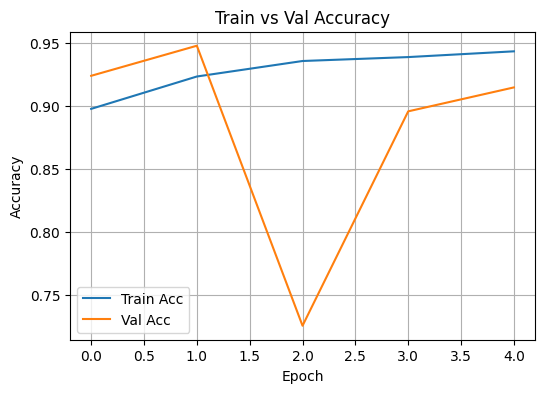

In [9]:
# ----------------------
# 0. Enhanced data augmentation + Edge channel
# ----------------------
class AddEdgeChannel:
    def __call__(self, img):
        arr = np.array(img)[:,:,::-1]
        edges = cv2.Canny(cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY),100,200)
        edges = Image.fromarray(edges).convert("L")
        r,g,b = img.split()
        return Image.merge("RGBA",(r,g,b,edges))

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.RandomRotation(15),
    AddEdgeChannel(),    # RGBA
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406,0.5],
                         std =[0.229,0.224,0.225,0.5])
])

# ----------------------
# 1. Dataset & Loaders
# ----------------------
class DogVsAiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "Images")
        self.label_dir = os.path.join(root_dir, "Labels")
        self.transform = transform
        self.names = [f.split('.')[0]
                      for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
    def __len__(self): return len(self.names)
    def __getitem__(self, idx):
        name = self.names[idx]
        img = Image.open(os.path.join(self.image_dir, name+".jpg")).convert("RGB")
        if self.transform: img = self.transform(img)
        lbl = int(open(os.path.join(self.label_dir, name+".txt")).read().strip())
        return img, lbl

train_ds = DogVsAiDataset("/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs/Dogs Vs AiDogs/Train", transform)
val_ds   = DogVsAiDataset("/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs/Dogs Vs AiDogs/Valid", transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)

# ----------------------
# 2. DualBranchNet (keep same)
# ----------------------
class DualBranchNet(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.global_backbone = models.resnet50(pretrained=True)
        orig1 = self.global_backbone.conv1
        self.global_backbone.conv1 = nn.Conv2d(
            4, orig1.out_channels, orig1.kernel_size,
            orig1.stride, orig1.padding, bias=(orig1.bias is not None))
        with torch.no_grad():
            self.global_backbone.conv1.weight[:,:3] = orig1.weight
            self.global_backbone.conv1.weight[:,3:4] = orig1.weight[:,:1]

        self.leg_backbone = models.resnet18(pretrained=True)
        orig2 = self.leg_backbone.conv1
        self.leg_backbone.conv1 = nn.Conv2d(
            4, orig2.out_channels, orig2.kernel_size,
            orig2.stride, orig2.padding, bias=(orig2.bias is not None))
        with torch.no_grad():
            self.leg_backbone.conv1.weight[:,:3] = orig2.weight
            self.leg_backbone.conv1.weight[:,3:4] = orig2.weight[:,:1]

        dim_g = self.global_backbone.fc.in_features
        dim_l = self.leg_backbone.fc.in_features
        self.classifier = nn.Sequential(
            nn.Linear(dim_g+dim_l,256), nn.ReLU(),
            nn.Dropout(0.5), nn.Linear(256,n_classes))

    def forward(self,x):
        # global
        g = self.global_backbone.conv1(x);  g = self.global_backbone.bn1(g)
        g = self.global_backbone.relu(g);   g = self.global_backbone.maxpool(g)
        g = self.global_backbone.layer1(g); g = self.global_backbone.layer2(g)
        g = self.global_backbone.layer3(g); g = self.global_backbone.layer4(g)
        g = self.global_backbone.avgpool(g);g = torch.flatten(g,1)
        # leg
        B,C,H,W = x.shape
        leg = x[:,:,int(H*0.5):,:]
        leg = nn.functional.interpolate(leg, size=(224,224))
        l = self.leg_backbone.conv1(leg);  l = self.leg_backbone.bn1(l)
        l = self.leg_backbone.relu(l);     l = self.leg_backbone.maxpool(l)
        l = self.leg_backbone.layer1(l);   l = self.leg_backbone.layer2(l)
        l = self.leg_backbone.layer3(l);   l = self.leg_backbone.layer4(l)
        l = self.leg_backbone.avgpool(l);  l = torch.flatten(l,1)
        return self.classifier(torch.cat([g,l],1))

# ----------------------
# 3. Training preparation: optimizer, scheduler, early stop vars
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualBranchNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p:p.requires_grad, model.parameters()),
    lr=1e-3, weight_decay=1e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True)

best_val = 0.0; epochs_no_improve=0; max_epochs_stop=3
num_epochs=10
history = {'train_acc':[], 'val_acc':[]}

# ----------------------
# 4. Training & Validation Loop (with Early Stopping)
# ----------------------
for ep in range(1,num_epochs+1):
    t0=time.time()
    # train
    model.train(); tp,tl= [],[]
    for imgs,labels in train_loader:
        imgs,labels=imgs.to(device),labels.to(device)
        optimizer.zero_grad()
        out = model(imgs); loss=criterion(out,labels)
        loss.backward(); optimizer.step()
        tp+=out.argmax(1).cpu().tolist()
        tl+=labels.cpu().tolist()
    train_acc=accuracy_score(tl,tp)

    # val
    model.eval(); vp,vl= [],[]
    with torch.no_grad():
        for imgs,labels in val_loader:
            imgs,labels=imgs.to(device),labels.to(device)
            out=model(imgs)
            vp+=out.argmax(1).cpu().tolist()
            vl+=labels.cpu().tolist()
    val_acc=accuracy_score(vl,vp)

    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {ep}/{num_epochs} "
          f"time {time.time()-t0:.1f}s "
          f"train_acc {train_acc:.4f} val_acc {val_acc:.4f}")

    # scheduler & early stop
    scheduler.step(val_acc)
    if val_acc>best_val:
        best_val=val_acc; epochs_no_improve=0
    else:
        epochs_no_improve+=1
    if epochs_no_improve>=max_epochs_stop:
        print(f"Early stopping at epoch {ep}")
        break

# ----------------------
# 5. Plot training/validation curves
# ----------------------
plt.figure(figsize=(6,4))
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'],   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend(); plt.grid(True)
plt.show()

# Lightweight 4-Channel Dual-Branch Model with MobileNet and OneCycleLR

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 131MB/s]

=== Start Dual‑Branch + Edge + OneCycleLR ===


Epoch 1/10 time 129.5s train_acc 0.9654 val_acc 0.9851
Epoch 2/10 time 131.7s train_acc 0.9776 val_acc 0.9801
Epoch 3/10 time 128.5s train_acc 0.9765 val_acc 0.9552
Epoch 4/10 time 128.8s train_acc 0.9805 val_acc 0.9782
Early stopping at epoch 4


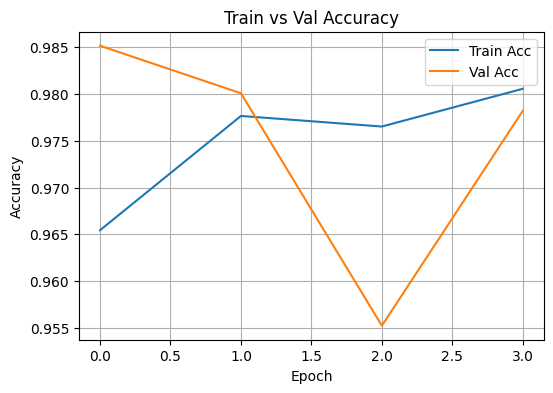

In [11]:
import os, time, cv2, numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import accuracy_score

# ======================
# 1. Edge channel + Data augmentation
# ======================
class AddEdgeChannel:
    def __call__(self, img):
        arr = np.array(img)[:,:,::-1]
        gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        edges = Image.fromarray(edges).convert("L")
        r,g,b = img.split()
        return Image.merge("RGBA", (r,g,b,edges))

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.85,1.0)),
    transforms.RandomHorizontalFlip(),
    AddEdgeChannel(),       # Generate RGBA
    transforms.ToTensor(),  # [4,224,224]
    transforms.Normalize(
        mean=[0.485,0.456,0.406,0.5],
        std =[0.229,0.224,0.225,0.5]
    )
])

# ======================
# 2. Dataset & DataLoader
# ======================
class DogVsAiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images = os.path.join(root_dir, "Images")
        self.labels = os.path.join(root_dir, "Labels")
        self.names = [f[:-4] for f in os.listdir(self.images) if f.endswith('.jpg')]
        self.transform = transform
    def __len__(self): return len(self.names)
    def __getitem__(self, i):
        n = self.names[i]
        img = Image.open(os.path.join(self.images, n+".jpg")).convert("RGB")
        if self.transform: img = self.transform(img)
        lbl = int(open(os.path.join(self.labels, n+".txt")).read().strip())
        return img, lbl

train_ds = DogVsAiDataset("/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs/Dogs Vs AiDogs/Train", transform)
val_ds   = DogVsAiDataset("/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs/Dogs Vs AiDogs/Valid", transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)

# ======================
# 3. Lightweight dual-branch model
# ======================
class DualBranchNet(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        # —— Backbone: MobileNetV2 RGBA —— 
        m = models.mobilenet_v2(pretrained=True)
        orig = m.features[0][0]  # first conv
        # Change to 4 channels
        new_conv = nn.Conv2d(4, orig.out_channels,
                             kernel_size=orig.kernel_size,
                             stride=orig.stride,
                             padding=orig.padding,
                             bias=False)
        with torch.no_grad():
            new_conv.weight[:,:3] = orig.weight
            new_conv.weight[:,3:4] = orig.weight[:,:1]
        m.features[0][0] = new_conv
        self.global_backbone = m
        dim_g = m.classifier[1].in_features

        # —— Leg branch: small CNN —— 
        self.leg_branch = nn.Sequential(
            nn.Conv2d(4, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2),                  # 16×112×112
            nn.Conv2d(16,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),                  # 32×56×56
            nn.AdaptiveAvgPool2d(1),          # 32×1×1
            nn.Flatten()                      # 32
        )
        dim_l = 32

        # —— Classification head —— 
        self.classifier = nn.Sequential(
            nn.Linear(dim_g+dim_l, 128),
            nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        # Global
        g = self.global_backbone.features(x)
        g = g.mean([2,3])  # global_pool
        # Leg: crop lower half
        B,C,H,W = x.shape
        leg = x[:,:,H//2:,:]
        leg = nn.functional.interpolate(leg, size=(224,224))
        l = self.leg_branch(leg)
        f = torch.cat([g,l], dim=1)
        return self.classifier(f)

# ======================
# 4. Loss, optimization, scheduling, early stopping
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualBranchNet().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# OneCycleLR: 5×steps_per_epoch total steps
epochs = 10
steps = epochs * len(train_loader)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, total_steps=steps
)
early_stop_patience = 3
best_val = 0
no_improve = 0

history = {'train_acc':[], 'val_acc':[]}

# ======================
# 5. Training & Validation Loop
# ======================
print("=== Start Dual-Branch + Edge + OneCycleLR ===")
step = 0
for ep in range(1, epochs+1):
    t0 = time.time()
    # train
    model.train()
    tp, tl = [], []
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        step += 1
        tp += out.argmax(1).cpu().tolist()
        tl += labels.cpu().tolist()
    train_acc = accuracy_score(tl, tp)

    # val
    model.eval()
    vp, vl = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            vp += out.argmax(1).cpu().tolist()
            vl += labels.cpu().tolist()
    val_acc = accuracy_score(vl, vp)

    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print(f"Epoch {ep}/{epochs} time {time.time()-t0:.1f}s "
          f"train_acc {train_acc:.4f} val_acc {val_acc:.4f}")

    # early stop
    if val_acc > best_val:
        best_val = val_acc
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= early_stop_patience:
            print(f"Early stopping at epoch {ep}")
            break

# ======================
# 6. Curve visualization
# ======================
plt.figure(figsize=(6,4))
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'],   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend(); plt.grid(True)
plt.show()

## Multi-Feature Extraction for Bayesian MLP: Global + Leg + Background Analysis

In [4]:
from ultralytics import YOLO
import torch
from torchvision import models, transforms
from PIL import Image, ImageDraw
import numpy as np
import os
from tqdm import tqdm

# 1. Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo = YOLO("yolov5su.pt")       # Use your downloaded su version
backbone = models.resnet50(pretrained=True)
feat_ex = torch.nn.Sequential(*list(backbone.children())[:-1]).to(device).eval()
preproc = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def get_bbox(img):
    # Turn off all log output, verbose=False
    res = yolo.predict(source=np.array(img),
                       conf=0.3, classes=[16], max_det=1,
                       verbose=False,  # <<< Key: no more printing
                       stream=False)  
    if len(res) == 0 or len(res[0].boxes) == 0:
        return None
    x1,y1,x2,y2 = res[0].boxes.xyxy[0].cpu().numpy().astype(int)
    return x1,y1,x2,y2

def extract_feat(img):
    t = preproc(img).unsqueeze(0).to(device)
    with torch.no_grad():
        f = feat_ex(t).flatten(1).cpu()  # [1,2048]
    return f

# 2. Batch processing and save
def preprocess_and_save(root_dir, out_path):
    images = sorted([f for f in os.listdir(os.path.join(root_dir,"Images")) if f.endswith(".jpg")])
    all_feats = []
    all_labels = []
    
    for name in tqdm(images, desc=out_path):
        img = Image.open(os.path.join(root_dir,"Images",name)).convert("RGB")
        lbl = int(open(os.path.join(root_dir,"Labels",name[:-4]+".txt")).read().strip())
        bbox = get_bbox(img)
        W,H = img.size
        
        # Full image
        f1 = extract_feat(img)
        
        # Lower half
        leg = img.crop((0,H//2,W,H)).resize((224,224))
        f2  = extract_feat(leg)
        
        # Background
        bg = Image.new("RGB",(W,H),(0,0,0))
        if bbox:
            mask = Image.new("L",(W,H),255)
            draw = ImageDraw.Draw(mask)
            draw.rectangle(bbox, fill=0)
            bg.paste(img,(0,0),mask)
        bg = bg.resize((224,224))
        f3 = extract_feat(bg)
        
        all_feats.append(torch.cat([f1,f2,f3],dim=1))
        all_labels.append(lbl)
    
    feats = torch.vstack(all_feats)     # [N, 6144]
    labels= torch.tensor(all_labels)   # [N]
    torch.save((feats, labels), out_path)

# Process Train/Valid separately
preprocess_and_save(
    "/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs/Dogs Vs AiDogs/Train", "train_feats.pt"
)
preprocess_and_save(
    "/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs/Dogs Vs AiDogs/Valid", "val_feats.pt"
)

val_feats.pt: 100%|██████████| 5317/5317 [04:49<00:00, 18.35it/s]


In [6]:
# 1. Feature Loading
feats_tr, labs_tr = torch.load("train_feats.pt")
feats_val, labs_val= torch.load("val_feats.pt")

train_ds = TensorDataset(feats_tr, labs_tr)
val_ds   = TensorDataset(feats_val, labs_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)

# 2. Define MLP
class SimpleMLP(nn.Module):
    def __init__(self, in_dim=6144, hidden=512, n_cls=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden, n_cls)
        )
    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 3. Train & Validate
for epoch in range(1,11):
    model.train()
    tr_preds, tr_labels = [], []
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss= criterion(out,y)
        loss.backward()
        optimizer.step()
        tr_preds += out.argmax(1).cpu().tolist()
        tr_labels+= y.cpu().tolist()
    tr_acc = accuracy_score(tr_labels, tr_preds)

    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            val_preds += out.argmax(1).cpu().tolist()
            val_labels+= y.cpu().tolist()
    val_acc=accuracy_score(val_labels,val_preds)
    print(f"Epoch {epoch}: Train {tr_acc:.4f} | Val {val_acc:.4f}")

Epoch 1: Train 0.9464 | Val 0.9624
Epoch 2: Train 0.9673 | Val 0.9829
Epoch 3: Train 0.9689 | Val 0.9812
Epoch 4: Train 0.9753 | Val 0.9812
Epoch 5: Train 0.9776 | Val 0.9840
Epoch 6: Train 0.9762 | Val 0.9827
Epoch 7: Train 0.9750 | Val 0.9778
Epoch 8: Train 0.9771 | Val 0.9759
Epoch 9: Train 0.9775 | Val 0.9705
Epoch 10: Train 0.9773 | Val 0.9823


# Combination: DINO+Bayesian MLP Augmented with Leg-Global Statistical Analysis

In [3]:
# ===== 1. YOLO & Feature Extractor Definition =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# YOLOv5 model
yolo_model = YOLO("yolov5su.pt")  
# Helper: get dog bbox from single image
def get_dog_bbox(img: Image.Image):
    # Turn off verbose to avoid screen flooding
    res = yolo_model.predict(
        source=np.array(img),
        conf=0.3,
        classes=[16],
        max_det=1,
        verbose=False,
        stream=False
    )
    if not res or not res[0].boxes:
        return None
    x1, y1, x2, y2 = res[0].boxes.xyxy[0].cpu().numpy().astype(int)
    return (x1, y1, x2, y2)

# Calculate grayscale mean difference: full image – leg region
def brightness_diff(img: Image.Image, bbox):
    gray = np.array(img.convert("L"), dtype=np.float32)
    full_mean = gray.mean()
    if bbox is None:
        return 0.0
    x1, y1, x2, y2 = bbox
    leg = gray[y1:y2, x1:x2]
    return float(full_mean - leg.mean()) if leg.size>0 else 0.0

# ===== 2. Batch concatenation and save function =====
def append_brightness_diff(feature_path, image_dir, out_path):
    # 2.1 Load original DINO features & labels
    feats, labels = torch.load(feature_path) 
    # 2.2 Read and sort all filenames
    names = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
    assert len(names) == feats.shape[0], "File count and feature count mismatch!"
    # 2.3 Concatenate
    new_feats = []
    for i, name in enumerate(tqdm(names, desc=os.path.basename(out_path))):
        img = Image.open(os.path.join(image_dir, name)).convert("RGB")
        bd  = brightness_diff(img, get_dog_bbox(img))
        # feats[i] is torch.Tensor([D]), bd is float
        new_feats.append(torch.cat([feats[i], torch.tensor([bd])]))
    new_feats = torch.stack(new_feats)  # [N, D+1]
    # 2.4 Save
    torch.save((new_feats, labels), out_path)
    print(f"Saved: {out_path} | new shape: {new_feats.shape}")

# ===== 3. Process train, val, test sequentially =====
base = "/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs/Dogs Vs AiDogs/"
append_brightness_diff(
    feature_path=os.path.join("/kaggle/input/features/features_train_full.pt"),
    image_dir=os.path.join(base, "Train", "Images"),
    out_path="features_train_plus.pt"
)
append_brightness_diff(
    feature_path=os.path.join("/kaggle/input/features/features_val_full.pt"),
    image_dir=os.path.join(base, "Valid", "Images"),
    out_path="features_val_plus.pt"
)
append_brightness_diff(
    feature_path=os.path.join("/kaggle/input/features/features_test_full.pt"),
    image_dir=os.path.join(base, "Test",  "Images"),
    out_path="features_test_plus.pt"
)

features_train_plus.pt: 100%|██████████| 18605/18605 [05:25<00:00, 57.17it/s]


Saved: features_train_plus.pt | new shape: torch.Size([18605, 385])


features_val_plus.pt: 100%|██████████| 5317/5317 [01:33<00:00, 57.05it/s]


Saved: features_val_plus.pt | new shape: torch.Size([5317, 385])


features_test_plus.pt: 100%|██████████| 2658/2658 [00:46<00:00, 57.25it/s]

Saved: features_test_plus.pt | new shape: torch.Size([2658, 385])


Epoch 01: Train 0.9482 | +Diff Val 0.9831
Epoch 02: Train 0.9726 | +Diff Val 0.9846
Epoch 03: Train 0.9740 | +Diff Val 0.9883
Epoch 04: Train 0.9786 | +Diff Val 0.9882
Epoch 05: Train 0.9796 | +Diff Val 0.9895
Epoch 06: Train 0.9824 | +Diff Val 0.9917
Epoch 07: Train 0.9817 | +Diff Val 0.9919
Epoch 08: Train 0.9834 | +Diff Val 0.9908
Epoch 09: Train 0.9850 | +Diff Val 0.9904
Epoch 10: Train 0.9861 | +Diff Val 0.9913


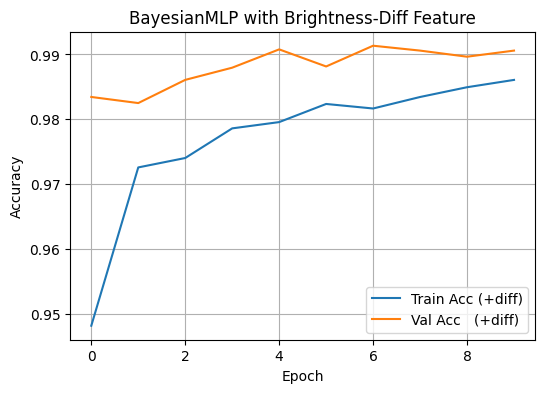

In [16]:
# 1. Load "+1" new feature
train_feats, train_lbls = torch.load("features_train_plus.pt")
val_feats,   val_lbls   = torch.load("features_val_plus.pt")

train_ds = TensorDataset(train_feats, train_lbls.float())
val_ds   = TensorDataset(val_feats,   val_lbls.float())
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

# 2. BayesianMLP (same as above)
class BayesianMLP(nn.Module):
    def __init__(self, input_dim, num_classes=1, dropout_rate=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze()

# 3. Instantiate & loss/optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = train_feats.shape[1]  # DINO_DIM + 1
model = BayesianMLP(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# 4. Training & record accuracy for +Brightness‑Diff
train_accs = []
plusdiff_val_accs = []

for epoch in range(1, 11):
    # — train —
    model.train()
    tp, tl = [], []
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        p = model(x)
        loss = criterion(p, y)
        loss.backward()
        optimizer.step()
        tp += (p>0.5).cpu().tolist()
        tl += y.cpu().tolist()
    train_acc = accuracy_score(tl, tp)
    train_accs.append(train_acc)
    
    # — val —
    model.eval()
    vp, vl = [], []
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            p = model(x)
            vp += (p>0.5).cpu().tolist()
            vl += y.cpu().tolist()
    val_acc = accuracy_score(vl, vp)
    plusdiff_val_accs.append(val_acc)
    
    print(f"Epoch {epoch:02d}: Train {train_acc:.4f} | +Diff Val {val_acc:.4f}")


# 5. Plot comparison curves
plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Acc (+diff)")
plt.plot(val_accs,   label="Val Acc   (+diff)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("BayesianMLP with Brightness-Diff Feature")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
torch.save(model.state_dict(), "plusdiff_model.pt")
print("Saved plusdiff_model.pt")

Saved plusdiff_model.pt


In [17]:
baseline_val_accs = [0.9883, 0.9859, 0.9882, 0.9872, 0.9900,
                     0.9895, 0.9900, 0.9895, 0.9900, 0.9891]

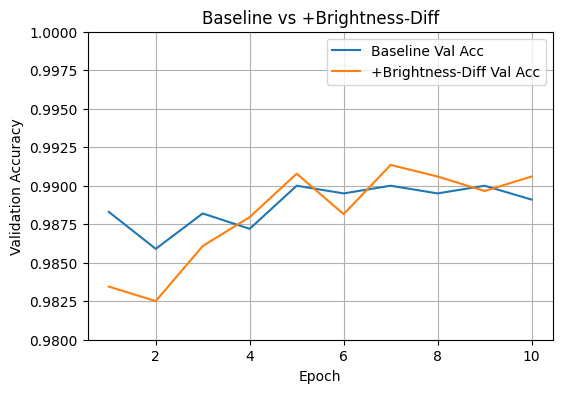

In [18]:
import matplotlib.pyplot as plt
epochs = range(1, len(baseline_val_accs)+1)

plt.figure(figsize=(6,4))
plt.plot(epochs, baseline_val_accs, label="Baseline Val Acc")
plt.plot(epochs, val_accs,            label="+Brightness‑Diff Val Acc")
plt.ylim(0.98, 1.0) 
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Baseline vs +Brightness‑Diff")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
import torch
from sklearn.metrics import accuracy_score

# First load features and labels
full_feats, full_lbls = torch.load("/kaggle/input/features/features_val_full.pt")
plus_feats, _         = torch.load("features_val_plus.pt")

# Use the same model weights to predict separately (assuming you saved two sets of models)
model_baseline = BayesianMLP(full_feats.shape[1]).to(device)
model_baseline.load_state_dict(torch.load("/kaggle/input/models/baseline_model.pt"))
model_plus    = BayesianMLP(plus_feats.shape[1]).to(device)
model_plus.load_state_dict(torch.load("plusdiff_model.pt"))

model_baseline.eval()
model_plus.eval()

# Batch prediction
with torch.no_grad():
    p_base = (model_baseline(full_feats.to(device)) > 0.5).cpu()
    p_plus = (model_plus( plus_feats.to(device)) > 0.5).cpu()
    truths = full_lbls.int()

# Statistics: baseline wrong but plus correct
fixed = ((p_base != truths) & (p_plus == truths)).sum().item()
total = len(truths)
print(f"In validation set of {total} images, brightness difference feature corrected {fixed} originally wrong predictions.")

In validation set of 5317 images, brightness difference feature corrected 30 originally wrong predictions.



=== Using Clean Layout with Text Boxes ===


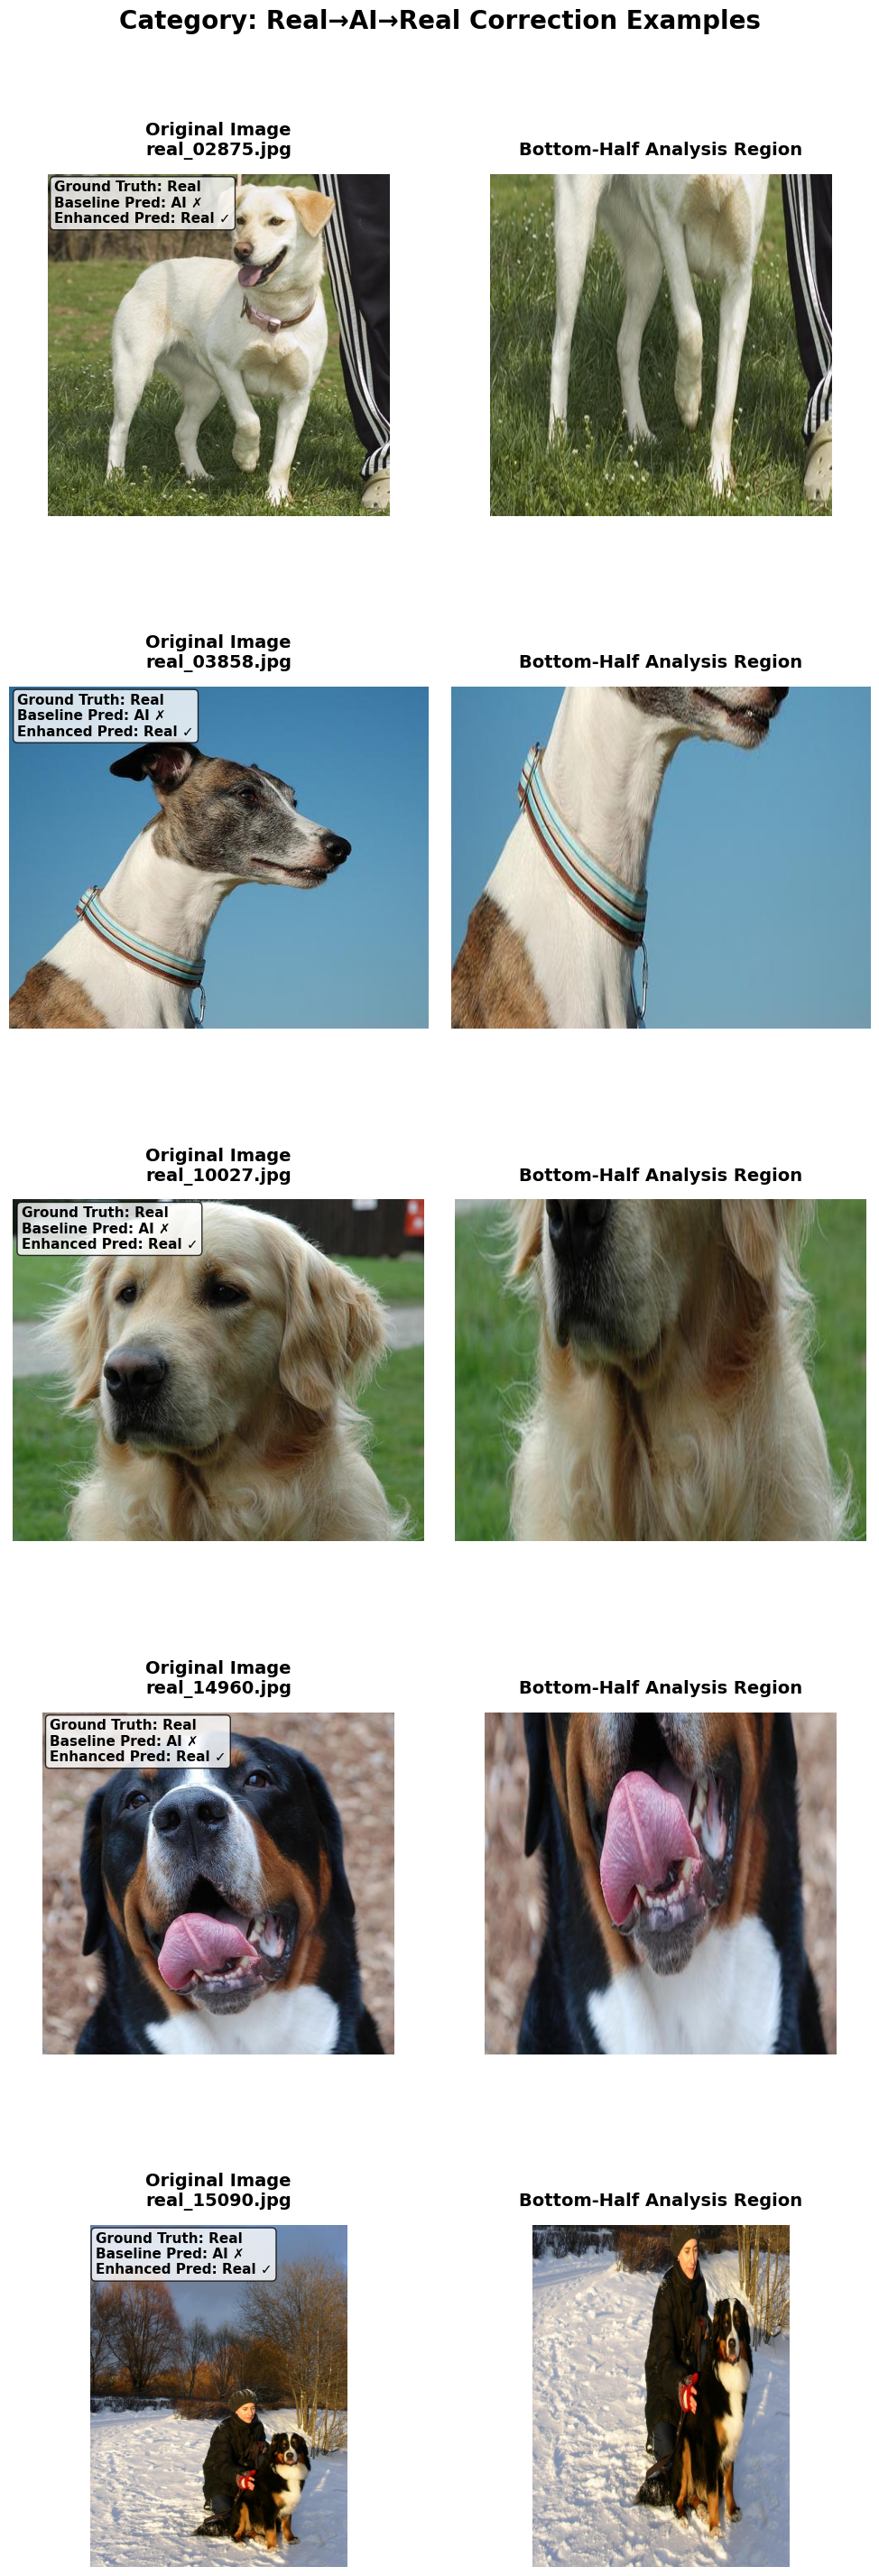

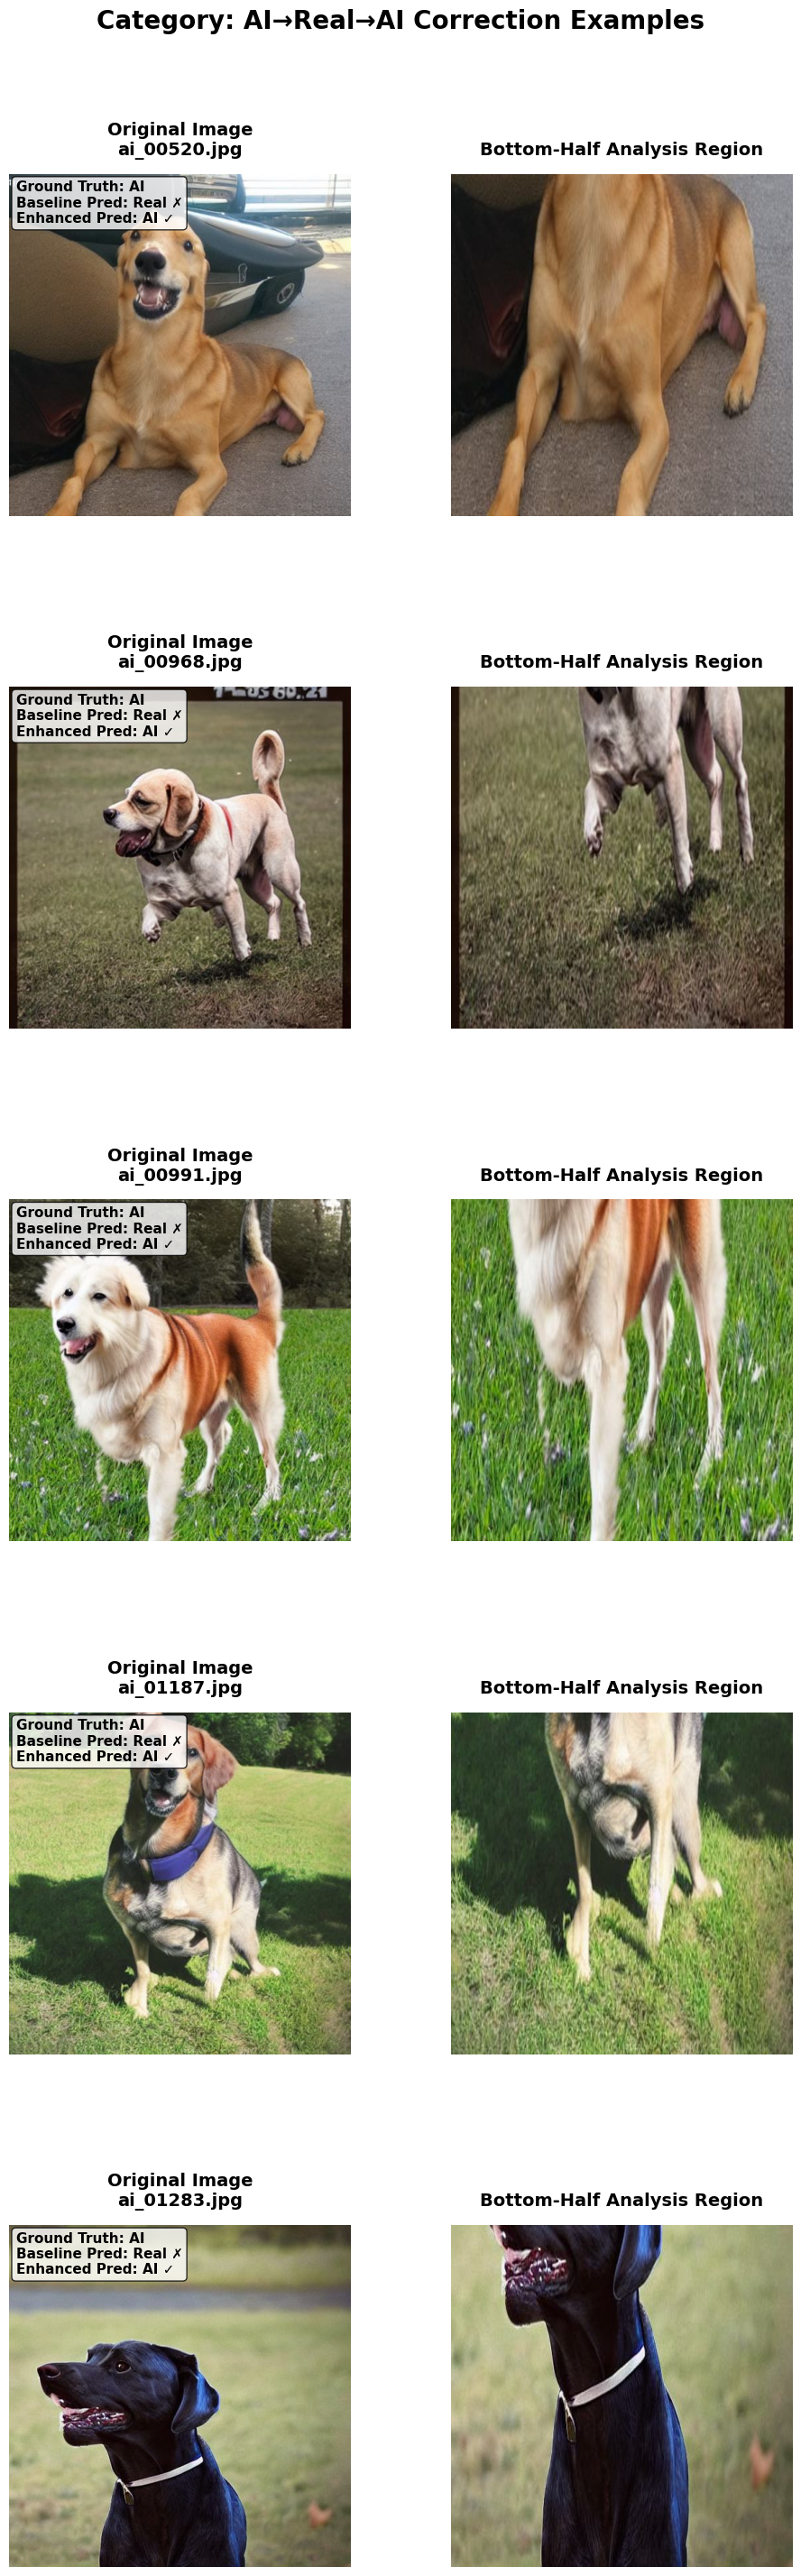

In [36]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# 1. Preparation: names, truths, p_base, p_plus (same as before)
image_dir = "/kaggle/input/ai-generated-dogs-jpg-vs-real-dogs-jpg/Dogs Vs AiDogs/Dogs Vs AiDogs/Valid/Images"
names = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
total = len(names)

# 2. Take first 5 correction samples from two categories  
corr_real = [i for i in range(total)
             if truths[i].item()==0 and p_base[i].item()==1 and p_plus[i].item()==0][:5]
corr_ai   = [i for i in range(total)
             if truths[i].item()==1 and p_base[i].item()==0 and p_plus[i].item()==1][:5]

# 3. Improved plotting function
def plot_group_clean(idxs, title):
    n = len(idxs)
    fig, axes = plt.subplots(n, 2, figsize=(10, 6*n))  # Reduced width from 14 to 12
    fig.suptitle(f"{title} Correction Examples", 
                 fontsize=20, y=0.95, fontweight='bold')
    
    for row, idx in enumerate(idxs):
        name = names[idx]
        img = Image.open(os.path.join(image_dir, name)).convert("RGB")
        W, H = img.size
        leg = img.crop((0, H//2, W, H)).resize((W, H))
        
        ax1, ax2 = axes[row]
        
        # Full image
        ax1.imshow(img)
        ax1.set_title(f"Original Image\n{name}", fontsize=14, pad=15, fontweight='bold')
        
        # Add text box with prediction info
        truth_val = truths[idx].item() 
        base_val = p_base[idx].item()
        enhanced_val = p_plus[idx].item()
        
        info_text = f"Ground Truth: {'Real' if truth_val==0 else 'AI'}\n"
        info_text += f"Baseline Pred: {'Real' if base_val==0 else 'AI'} {'✓' if base_val==truth_val else '✗'}\n"
        info_text += f"Enhanced Pred: {'Real' if enhanced_val==0 else 'AI'} {'✓' if enhanced_val==truth_val else '✗'}"
        
        ax1.text(0.02, 0.98, info_text, transform=ax1.transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                verticalalignment='top', fontsize=11, fontweight='bold')
        ax1.axis('off')
        
        # Bottom half
        ax2.imshow(leg)
        ax2.set_title("Bottom-Half Analysis Region", fontsize=14, pad=15, fontweight='bold')
        ax2.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.subplots_adjust(hspace=0.5, wspace=0.02)  # Reduced wspace from 0.3 to 0.1
    plt.show()

# 4. Display with improved layout
print("\n=== Using Clean Layout with Text Boxes ===")
plot_group_clean(corr_real, "Category: Real→AI→Real")
plot_group_clean(corr_ai,   "Category: AI→Real→AI")